In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys

import time
from stacked_model import *
import Gamma_error as gm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

## Discrete action

\begin{equation}
S[\phi] = \sum_{x} \left[ 
    \frac{1}{2} \tilde{m} \, \phi(x)^2 
    + \frac{\lambda}{24} \, \phi(x)^4 
    - \sum_{\mu=1}^{N_d} \phi(x) \, \phi(x + \hat{\mu}) 
\right]
\end{equation}

## Generalize phi4 to any d

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  10 9:38:24 2019

@author: Kostas Orginos
I have just modified it to work on arbitrary dimensions and do checks

"""

import numpy as np
import torch as tr

class phi4():
    def action(self,phi):
        #A = 0.5*self.mtil*tr.einsum('bxy,bxy->b',phi,phi) + (self.lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))

        phi2 = phi*phi
        #A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2,dim=(1,2))
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.sum(phi*tr.roll(phi,shifts=-1,dims=mu),dim=(1,2))

            
        A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2, dim=tuple(range(1, self.Nd+1)))
        for mu in range(1, self.Nd+1):
            A = A - tr.sum(phi * tr.roll(phi, shifts=-1, dims=mu), dim=tuple(range(1, self.Nd+1)))
        return A
    
    def force(self,phi):
        F = -self.mtil*phi - self.lam*phi**3/6.0
        for mu in range(1,self.Nd+1):
            F +=  tr.roll(phi,shifts= 1,dims=mu)+tr.roll(phi,shifts=-1,dims=mu)
        return F


    def refreshP(self):
        shape = [self.Bs] + list(self.V)
        P = tr.normal(0.0,1.0,shape,dtype=self.dtype,device=self.device)
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        spatial_dims = ''.join(chr(ord('a') + i) for i in range(self.Nd))#abcd for d=4
        einsum_str = f"z{spatial_dims},z{spatial_dims}->z"
        return tr.einsum(einsum_str,P,P)/2.0

    def hotStart(self):
        shape = [self.Bs] + list(self.V)
        sigma = tr.normal(0.0, 1.0, shape, dtype=self.dtype, device=self.device)
        return sigma
    
    def __init__(self,V,l,m,batch_size=1,device="cpu",dtype=tr.float32): 
            self.V = tuple(V) # lattice size
            self.Vol = np.prod(V)
            self.Nd = len(V)
            self.lam = l # the coupling
            self.mass  = m
            self.mtil = m + 2*self.Nd
            self.Bs=batch_size
            self.device=device
            self.dtype=dtype



def main():
    import time
    import matplotlib.pyplot as plt
    
    device = "cuda" if tr.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    L=32
    batch_size=1
    lam =0.1
    mass= 0.1
    o = phi4([L],lam,mass,batch_size=batch_size, device=device, dtype=tr.float32)

    phi=o.hotStart()
    #plt.imshow(phi[0,:,:,1,2].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    #plt.show()
    print(f"phi shape {phi.shape} dtype {phi.dtype} device {phi.device}")
    tic=time.perf_counter()
    Niter=10000
    for k in range(Niter):
        o.action(phi)
    toc=time.perf_counter()
    print(f"action time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")

    tic=time.perf_counter()
    for k in range(Niter):
        o.force(phi)
    toc=time.perf_counter()
    print(f"force time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

    P = o.refreshP()

    tic=time.perf_counter()
    for k in range(Niter):
        o.kinetic(phi)
    toc=time.perf_counter()
    print(f"kinetic time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

if __name__ == "__main__":
   main()

Using cuda device
phi shape torch.Size([1, 32]) dtype torch.float32 device cuda:0
action time 79.4677 micro-seconds
force time 74.4008 micro-seconds
kinetic time 35.9149 micro-seconds


In [ ]:
class NonLinearRGlayer(nn.Module):
    def __init__(self, channels=1, hidden_channels=8, batch_size=1):
        super(NonLinearRGlayer, self).__init__()
        self.batch_size = batch_size
        
        # Restrictor: one small conv + downsampling
        self.restrict_net = nn.Sequential(
            nn.Conv2d(channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, channels, kernel_size=1, stride=2)
        )

        # Prolongator: upsampling + conv
        self.prolong_net = nn.Sequential(
            nn.ConvTranspose2d(channels, hidden_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, channels, kernel_size=1)
        )

    def coarsen(self, f):
        ff = f.view(f.shape[0], 1, f.shape[1], f.shape[2])  # B x 1 x H x W
        c = self.restrict_net(ff)
        r = ff - self.prolong_net(c)
        if self.batch_size == 1:
            return c.squeeze(1), r.squeeze(1)
        else:
            return c.squeeze(), r.squeeze()

    def refine(self, c, r):
        cc = c.view(c.shape[0], 1, c.shape[1], c.shape[2])
        rr = r.view(r.shape[0], 1, r.shape[1], r.shape[2])
        f_rec = self.prolong_net(cc) + rr
        if self.batch_size == 1:
            return f_rec.squeeze(1)
        else:
            return f_rec.squeeze()
    

## Some observables

Phase in the code $\delta_n=e^{\frac{2i\pi}{L}n}$ with $p_n=\frac{2\pi}{L}n$

\begin{align}
\text{Field average or magnetization:} \quad
\langle \phi \rangle &= \frac{1}{V} \sum_x \phi(x) \\[8pt]
\text{Magnetic susceptibility:} \quad
\chi_m &= V \cdot \langle \phi \rangle^2 \\[8pt]
\text{Two-point correlator at momentum $p$}: \quad
C_2(p) &= V \cdot \left| \frac{1}{V} \sum_x \phi(x) \, e^{i p_n x} \right|^2 \\[8pt]
\text{Energy density:} \quad
E &= \frac{S[\phi]}{V}
\end{align}

In [4]:
#!/usr/local/bin/python3
import time
import numpy as np
import torch as tr
import phi4 as s
import integrators as i
import update as u

import matplotlib.pyplot as plt

device = "cuda" if tr.cuda.is_available() else "cpu"
if(device=="cpu"):
    device = "mps" if tr.backends.mps.is_available() else "cpu"
# OK I will always use CPU for now
device = "cpu"
device = tr.device(device)
print(f"Using {device} device")

    
def jackknife(d):
    # d is the list containing data
    # NOTE: it works with python lists not numpy arrays
    #
    N=len(d) -1 
    ss = sum(d)
    r=[]
    for n in range(len(d)):
        r.append((ss-d[n])/N)

    return r

def average(d):
    m = np.mean(d)
    e = np.std(d)/np.sqrt(len(d)-1)
    return m,e

def correlation_length(L,ChiM,C2p):
     return 1/(2*np.sin(np.pi/L))*np.sqrt(ChiM/C2p -1)

Using cpu device


## Gamma analysis (wolff)

### eliminate this

In [48]:
def get_observables_hist(sg,hmc, phi, Nwarm, Nmeas, Nskip):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]),dtype=sg.dtype,device=sg.device)
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.append(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.append(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%100==0) and device=="cpu":
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
            print("len(C2p): ", len(C2p))
        lC2p.append(C2p)
        lchi_m.append(chi_m)
        ## HMC update but also V cycle
        phi = hmc.evolve(phi,Nskip)

    return lC2p, lchi_m, E, av_phi, phi

def get_observables(lC2p, lchi_m, E, av_phi, phi):

    Vol=phi.shape[1]*phi.shape[2]
    lat=[phi.shape[1], phi.shape[2]]
    
    m_phi, e_phi = average(av_phi)
    print("m_phi: ",m_phi,e_phi)

    m_chi_m, e_chi_m = average(np.array(lchi_m) - (m_phi**2)*Vol)
    m_C2p, e_C2p     = average(lC2p)
    print(r"$\chi_m$: ",m_chi_m,'+/-', e_chi_m)
    print("C2p  : ",m_C2p,'+/-', e_C2p)
    avE,eE = average(E)
    print("E = ", avE ,'+/-',eE)

    xi = correlation_length(lat[0],m_chi_m, m_C2p)
    print("The correlation length is: ",xi)
    jphi   = np.array(jackknife(av_phi))
    jchi_m = np.array(jackknife(lchi_m)) - jphi**2 * Vol
    jC2p   = np.array(jackknife(lC2p))


    j_xi = correlation_length(lat[0],jchi_m,jC2p)

    m_xi,e_xi = average(j_xi)

    return m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi


def autocorrelation1(trace):
    #divide trace in 2
    trace=trace[0:trace.shape[0]]
    n=trace.shape[0]
    mean=tr.mean(trace)
    var=tr.var(trace)
    autocorr=tr.zeros_like(trace)
    for k in range(0,n-1):
        autocorr[k]=tr.sum((trace[0:n-k]-mean)*(trace[k:n]-mean))/(var*(n-k))
    return autocorr

    
def autocorrelation(trace):
    x = tr.as_tensor(trace, dtype=tr.float64)
    n = x.shape[0]
    x = x - x.mean()
    var = x.var(unbiased=False)
    acf = tr.zeros(n, dtype=x.dtype)
    for k in range(n):
        acf[k] = tr.dot(x[:n-k], x[k:]) / (var * (n - k))
    return acf # acf[0] == 1

#τ_int (Sokal: τ_int = 0.5 + sum_{t=1}^W ρ_t)
def integrated_autocorrelation_time(acf, max_lag=None):
    x = tr.as_tensor(acf, dtype=tr.float64)
    if x[0].abs().item() > 0:
        x = x / x[0]
    n = x.shape[0]
    if max_lag is None:
        W = 0
        for t in range(1, n):
            if (x[t] <= 0).item():
                break
            W = t
    else:
        W = min(int(max_lag), n - 1)
    return float(0.5 + x[1:W+1].sum().item())

def integrated_autocorrelation_time1(acf, max_lag=None):
    if max_lag is None:
        for t in range(1, len(acf)):
            if acf[t] < 0:
                max_lag = t
                break
        else:
            max_lag = len(acf) - 1
    return 0.5 + tr.sum(acf[1:max_lag])
def get_autocorrelationtime(av_phi, lchi_m):
    
    acf_phi = autocorrelation(tr.tensor(av_phi))
    #acf_phi = acf_phi / acf_phi[0]
    acf_suscept = autocorrelation(tr.tensor(lchi_m))
    max_lag=len(av_phi)//4
    print(acf_phi.shape)
    tau_int_phi = integrated_autocorrelation_time(acf_phi,max_lag)
    tau_int_suscept = integrated_autocorrelation_time(acf_suscept,max_lag)
    return tau_int_phi, tau_int_suscept

In [52]:
device="cuda"

In [53]:

import integrators as i

mass_grid=np.linspace(-.58,-0.55,11)
L=128
lat = [L,L]
# This set of params is very very close to critical.
lam = 2.4
mas = -0.58
#
Nwarm = 100
Nmeas = 300
Nskip = 1
batch_size = 10

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device,dtype=tr.float64)
phi = sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)

lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
#tau_phi,tau_chi = get_autocorrelationtime(av_phi, lchi_m)
#m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 128, 128]) 16384 tensor(0.0024, device='cuda:0', dtype=torch.float64) tensor(0.9971, device='cuda:0', dtype=torch.float64)
time 0.0382 micro-seconds per HMC trajecrory


In [ ]:
import math

def compute_gradient_autograd(f, mean_a):
    """
    Compute gradient df/dA_alpha using autograd at the mean point.
    Related to Eq. (17): f_alpha = df / dA_alpha
    """
    mean_a = mean_a.clone().detach().requires_grad_(True)
    f_value = f(mean_a)
    f_value.backward()
    return mean_a.grad.detach()

def project_observable(data: tr.Tensor, grad_f: tr.Tensor) -> tr.Tensor:
    """
    Project a_i^alpha to a_i^f using the gradient direction.
    Implements Eq. (37): a_i^f = sum_alpha f_alpha * a_i^alpha
    """
    return data @ grad_f

def autocorrelation_proj(data: tr.Tensor) -> tr.Tensor:
    """
    Estimate normalized autocorrelation function Γ_F(t)/Γ_F(0).
    Related to Eq. (31) and Eq. (33): autocorrelation of projected observable
    """
    N = len(data)
    mean = data.mean()
    var = data.var(unbiased=True)
    acf = tr.zeros(N)
    for t in range(N):
        acf[t] = ((data[:N - t] - mean) * (data[t:] - mean)).mean()
    return acf / var  # Normalized Γ_F(t)

def integrated_autocorrelation_time(acf: tr.Tensor, W: int) -> float:
    """
    Compute τ_int,F from Eq. (25), truncated at window W.
    Eq. (23): σ² = (2 τ_int,F / N) * v_F
    Eq. (25): τ_int,F = (1 / 2 v_F) * sum_t sum_alphaβ f_alpha f_beta Γ_alphaβ(t)
    """
    return 0.5 + acf[1:W+1].sum().item()

def compute_tau_hat(tau_int: float) -> float:
    """
    Estimate tau_hat(W) used in windowing criterion.
    Based on Eq. (51): expansion of S / tau_hat
    """
    if tau_int <= 0.5:
        return 1e-10
    return 1.0 / tau_int + 1.0 / (12.0 * tau_int**3)

def g_function(W: int, tau_hat: float, N: int) -> float:
    """
    Criterion function g(W) for automatic window selection.
    Implements Eq. (52): g(W) = exp(-W / τ_hat) - τ_hat / sqrt(W N)
    """
    return math.exp(-W / tau_hat) - tau_hat / math.sqrt(W * N)

def find_optimal_window(acf: tr.Tensor, N: int, S: float = 1.5, maxW: int = 100) -> int:
    """
    Automatic window selection based on minimization of total error.
    Eq. (43): total error = exp(-W/τ) + 2 √(W/N)
    Implements algorithm described in Section 3.3, Eq. (50)–(52)
    """
    for W in range(1, min(maxW, N // 2)):
        tau_int = integrated_autocorrelation_time(acf, W)
        tau_hat = compute_tau_hat(tau_int * S)
        if g_function(W, tau_hat, N) < 0:
            return W
    return min(maxW, N // 2)

def gamma_method_with_replicas(data_replicas: list, f, S: float = 1.5):
    """
    Full Γ-method implementation for derived observable f with multiple replicas.
    Based on Wolff's 2006 paper hep-lat/0306017v4:
    - Eq. (17) for f_α
    - Eq. (21–25) for error and τ_int estimation
    - Eq. (31–35) for autocorrelation estimators
    - Eq. (43–52) for optimal window selection
    """
    # Concatenate all replicas to estimate overall mean A_alpha (Eq. 7)
    all_data = tr.cat(data_replicas, dim=0)
    mean_a = all_data.mean(dim=0)

    # Compute gradient f_α at mean A_α using autograd (Eq. 17)
    grad_f = compute_gradient_autograd(f, mean_a)

    # Project a_i^α → a_i^f (Eq. 37)
    projected_replicas = [project_observable(replica, grad_f) for replica in data_replicas]

    # Average autocorrelation Γ_F(t) over replicas (Eq. 31, then Eq. 33)
    acf_total = None
    total_N = 0
    for projected in projected_replicas:
        acf = autocorrelation_proj(projected)
        N = len(projected)
        acf_total = acf[:N] if acf_total is None else acf_total[:min(len(acf_total), N)] + acf[:min(len(acf_total), N)]
        total_N += N
    acf_avg = acf_total / len(data_replicas)

    # Determine optimal summation window W (Section 3.3, Eq. 52)
    W_opt = find_optimal_window(acf_avg, total_N, S=S)

    # Compute τ_int,F from truncated sum (Eq. 25)
    tau_int = integrated_autocorrelation_time(acf_avg, W_opt)

    # Compute variance of mean (Eq. 23): σ² = (2 τ_int,F / N) * v_F
    var_f = acf_avg[0] * (2 * tau_int / total_N)

    return {
        "mean": f(mean_a).item(),         # Eq. (14)
        "tau_int": tau_int,               # Eq. (25)
        "window": W_opt,                  # Eq. (52)
        "error²": var_f.item(),           # Eq. (23)
        "error": math.sqrt(var_f.item()), # Eq. (23)
        "grad_f": grad_f                  # Eq. (17)
    }

In [14]:
"""import torch as tr
tr.manual_seed(0)

N_total = 10000
obs = tr.exp(1.0 + 0.1 * tr.randn(N_total))  # A0 > 0
data = obs.unsqueeze(1)  # Shape [N, 1]
replicas =  tr.chunk(data, 5) # lista de 5 tensores [~2000, 1]
"""
rep_ten=tr.stack(av_phi).T.unsqueeze(2)
replicas = gm.split_first_dim_to_list(rep_ten)

print(tr.stack(replicas).shape, rep_ten.shape)

f = lambda A: A[0]
results = gm.gamma_method_with_replicas(replicas, f)
print(f"F = {results['value']:.6f} ± {results['dvalue']:.6f} (±{results['ddvalue']:.6f})")
print(f"tau_int = {results['tau_int']:.3f} ± {results['dtau_int']:.3f}")
print(f"W_opt = {results['W_opt']}, Q = {results['Q']}")



torch.Size([20, 3000, 1]) torch.Size([20, 3000, 1])
F = -0.013544 ± 0.056038 (±0.000574)
tau_int = 94.208 ± 1.929
W_opt = 100, Q = 0.0


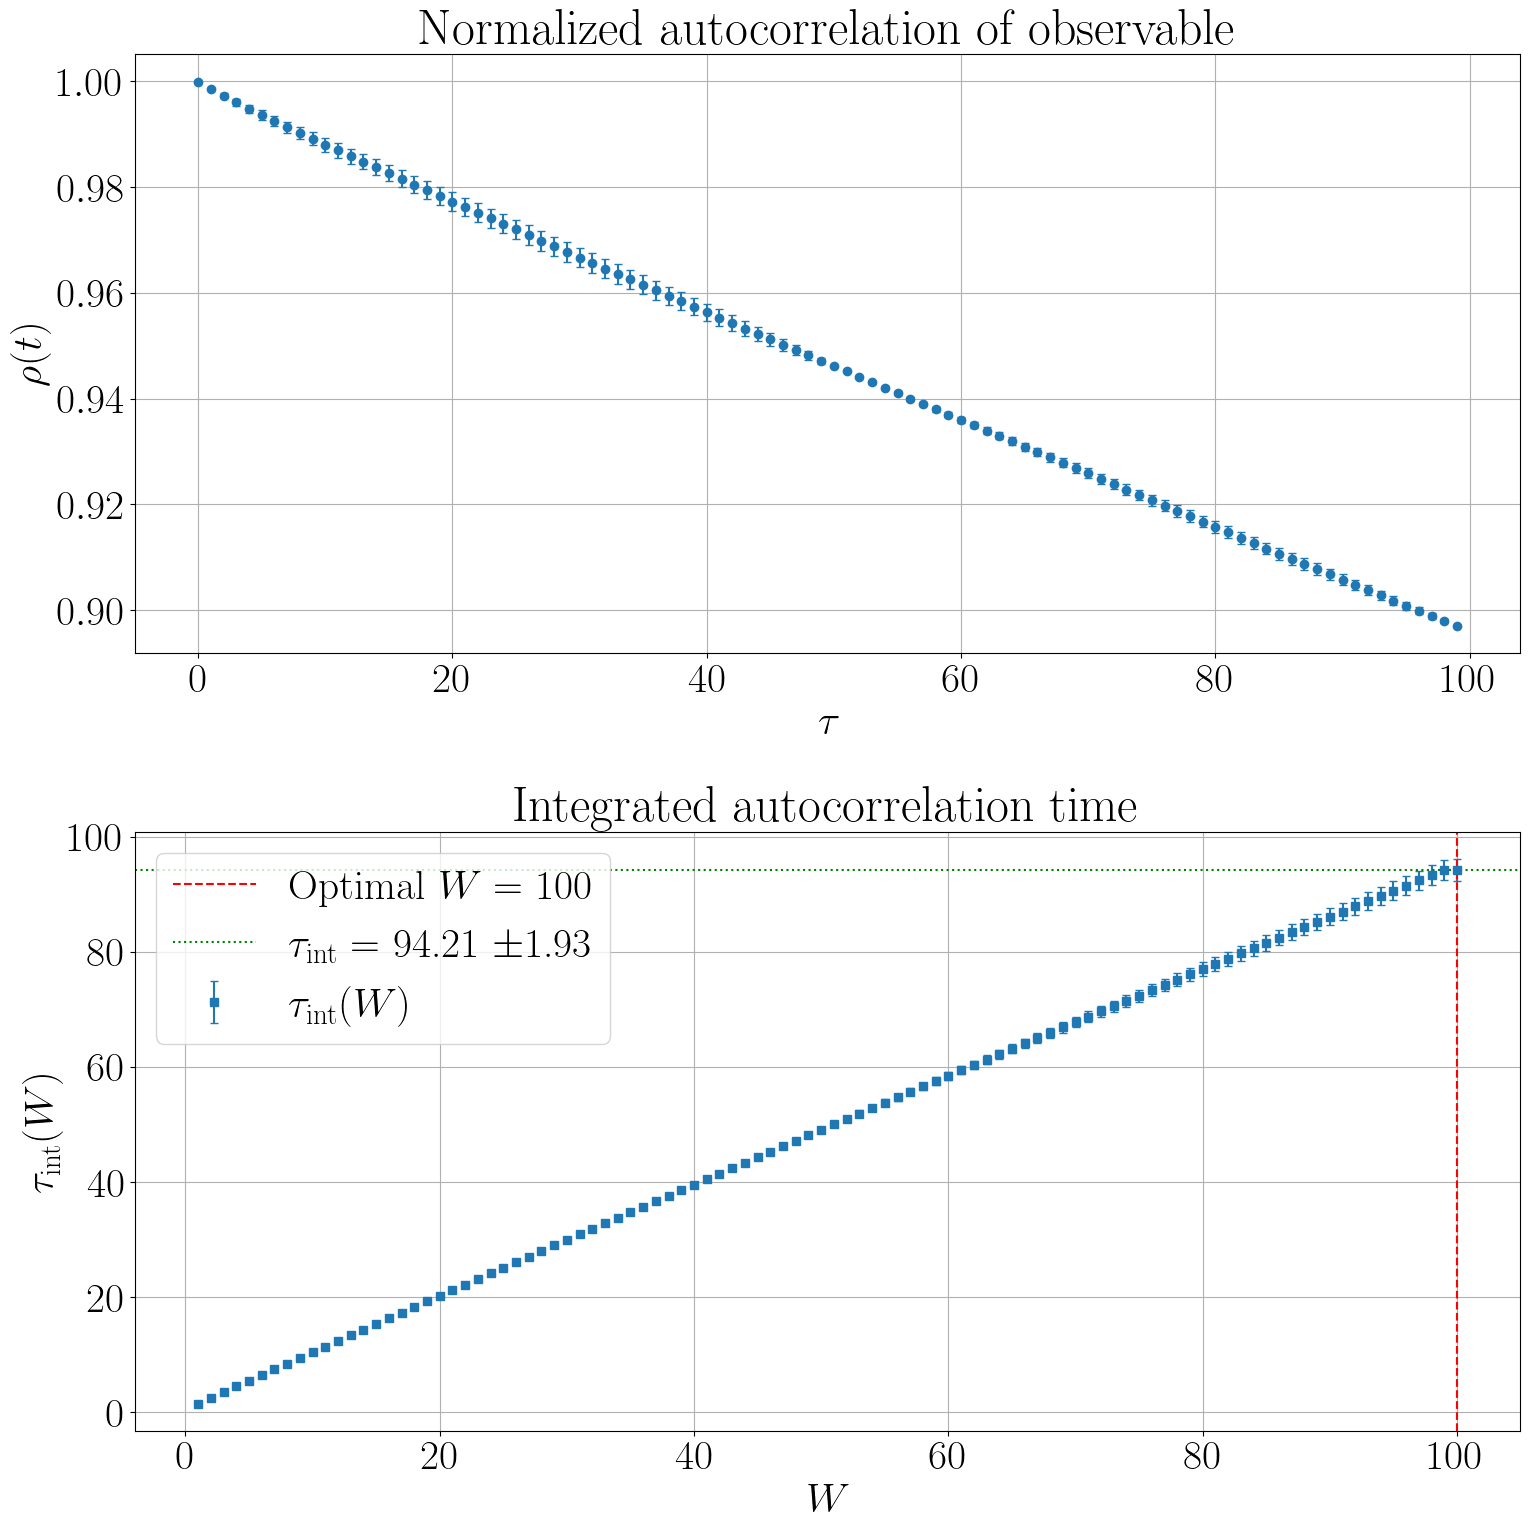

In [15]:
gm.plot_figure_2(results,max_lag=200)

In [92]:
tr.tensor(hmc.AcceptReject).sum()/len(hmc.AcceptReject)

tensor(0.9837)

In [22]:

mass_grid1=np.linspace(-.585,-0.54,6)
tau_phi1=np.zeros_like(mass_grid1)
tau_suscept1=np.zeros_like(mass_grid1)
dtau_phi1=np.zeros_like(mass_grid1)
dtau_suscept1=np.zeros_like(mass_grid1)
phi_av_mean=np.zeros_like(mass_grid1)
phi_av_std=np.zeros_like(mass_grid1)
sucept_mean=np.zeros_like(mass_grid1)
sucept_std=np.zeros_like(mass_grid1)
sss=0
for mas in mass_grid1:
    L=128
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 1000
    Nmeas = 10000
    Nskip = 1
    batch_size = 10

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)

    lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
    #tau_phi1[sss],tau_suscept1[sss] = get_autocorrelationtime(av_phi, lchi_m)
    results_av = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(av_phi).T.unsqueeze(2)), lambda A: A[0])
    results_lchi = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(lchi_m).T.unsqueeze(2)), lambda A: A[0])
    tau_phi1[sss]=results_av['tau_int']
    tau_suscept1[sss]=results_lchi['tau_int']
    dtau_phi1[sss]=results_av['dtau_int']
    dtau_suscept1[sss]=results_lchi['dtau_int']
    phi_av_mean[sss]=results_av['value']
    phi_av_std[sss]=results_av['dvalue']
    sucept_mean[sss]=results_lchi['value']
    sucept_std[sss]=results_lchi['dvalue']
    print("Gamma results for average phi:")
    print(f"F = {results_av['value']:.6f} ± {results_av['dvalue']:.6f} (±{results_av['ddvalue']:.6f})")
    print(f"tau_int = {results_av['tau_int']:.3f} ± {results_av['dtau_int']:.3f}")
    print(f"W_opt = {results_av['W_opt']}, Q = {results_av['Q']}")
    print("Gamma results for susceptibility:")
    print(f"F = {results_lchi['value']:.6f} ± {results_lchi['dvalue']:.6f} (±{results_lchi['ddvalue']:.6f})")
    print(f"tau_int = {results_lchi['tau_int']:.3f} ± {results_lchi['dtau_int']:.3f}")
    print(f"W_opt = {results_lchi['W_opt']}, Q = {results_lchi['Q']}")
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 128, 128]) 16384 tensor(-0.0004) tensor(1.0029)
time 0.0029 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.00037911406 0.78629816 0.8647147404731472 2.0191133
len(C2p):  10
k=  10 (av_phi,chi_m, c2p, E)  -0.002573313 2.3452122 1.6915237822540732 1.7450216
len(C2p):  10
k=  20 (av_phi,chi_m, c2p, E)  -0.008395276 6.3925557 9.325127743652287 1.5689653
len(C2p):  10
k=  30 (av_phi,chi_m, c2p, E)  -0.0030945528 6.0270004 8.227015305768283 1.3913428
len(C2p):  10
k=  40 (av_phi,chi_m, c2p, E)  -1.5505706e-05 11.215364 6.987836465239849 1.378331
len(C2p):  10
k=  50 (av_phi,chi_m, c2p, E)  0.0039354833 5.7863784 11.692733610230954 1.3748605
len(C2p):  10
k=  60 (av_phi,chi_m, c2p, E)  -0.006667075 13.544554 15.950416621219063 1.2649381
len(C2p):  10
k=  70 (av_phi,chi_m, c2p, E)  -0.022311589 36.942924 16.67057686812383 1.2174352
len(C2p):  10
k=  80 (av_phi,chi_m, c2p, E)  -0.031820994 53.758476 22.0439681689535 1.2122118
len(C2p):  10
k=  90 (av_phi,chi_m

In [35]:
device = tr.device("cpu")
dev=1
# Check that MPS is available
if not tr.backends.mps.is_available():
    if not tr.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("mps")

# Check that CUDA is available
if not tr.cuda.is_available():
    if not tr.backends.cuda.is_built():
        print("CUDA not available because the current PyTorch install was not "
              "built with CUDA enabled.")
    else:
        print("CUDA not available or you do not have a GPU on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("cuda:"+str(dev))


    
print(f"Using {device} device")

MPS not available because the current PyTorch install was not built with MPS enabled.
Using cuda:1 device


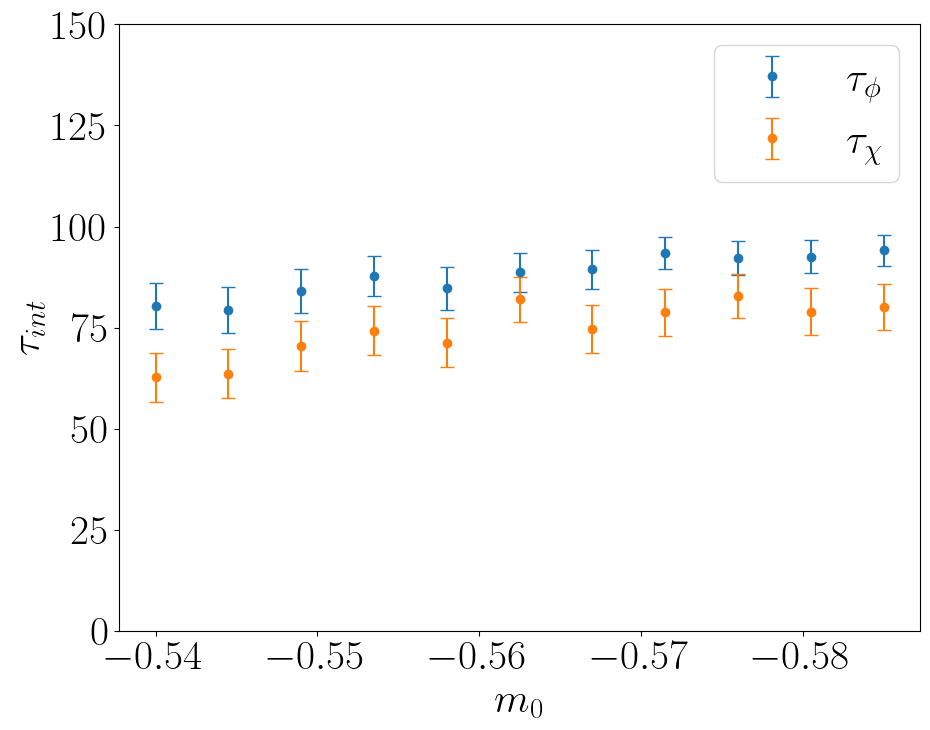

In [20]:
#plot mass vs tau
plt.figure(figsize=(10,8))
#reverse mass axis
plt.gca().invert_xaxis()
#plt.plot(mass_grid1,tau_phi1,'o-',label=r'$\tau_{\phi}$')
#plt.plot(mass_grid1,tau_suscept1,'o-',label=r'$\tau_{\chi}$')
#error bar format
plt.errorbar(mass_grid1,tau_phi1,yerr=dtau_phi1,fmt='o',label=r'$\tau_{\phi}$',capsize=5)
plt.errorbar(mass_grid1,tau_suscept1,yerr=dtau_suscept1,fmt='o',label=r'$\tau_{\chi}$',capsize=5)
plt.xlabel(r'$m_0$', fontsize=30)
plt.ylabel(r'$\tau_{int}$', fontsize=30)
plt.ylim(0,150)
#plt.yscale('log')
plt.legend(fontsize=30)

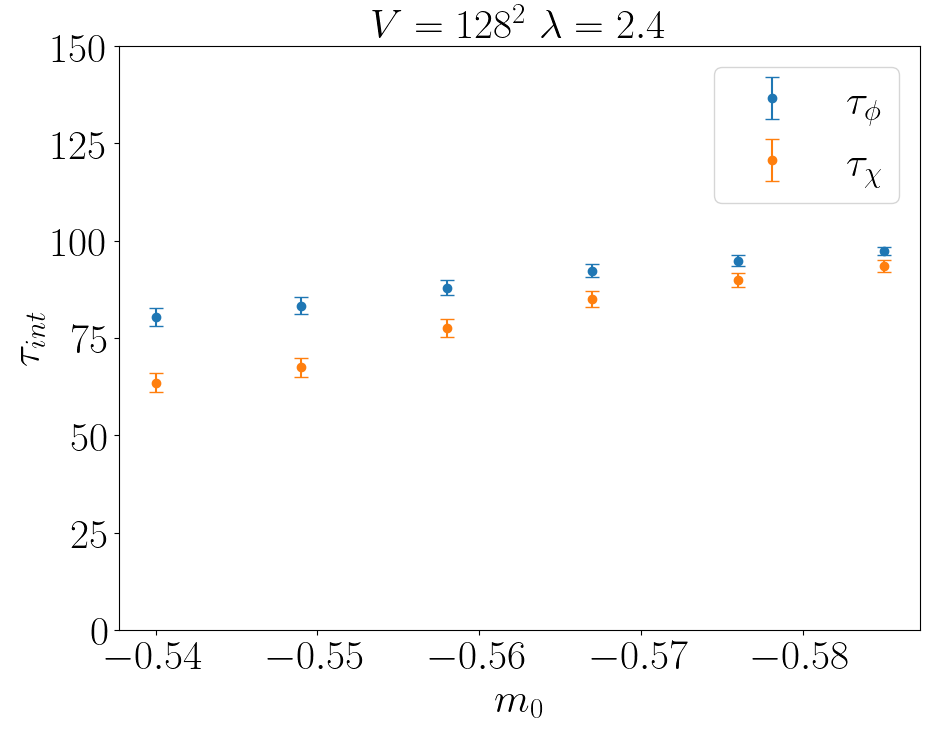

In [33]:
#plot mass vs tau
plt.figure(figsize=(10,8))
#reverse mass axis
plt.gca().invert_xaxis()
plt.title(r"$V=128^2$ $\lambda=2.4$", fontsize=30)
#plt.plot(mass_grid1,tau_phi1,'o-',label=r'$\tau_{\phi}$')
#plt.plot(mass_grid1,tau_suscept1,'o-',label=r'$\tau_{\chi}$')
plt.errorbar(mass_grid1,tau_phi1,yerr=dtau_phi1,fmt='o',label=r'$\tau_{\phi}$',capsize=5)
plt.errorbar(mass_grid1,tau_suscept1,yerr=dtau_suscept1,fmt='o',label=r'$\tau_{\chi}$',capsize=5)
plt.xlabel(r'$m_0$', fontsize=30)
plt.ylabel(r'$\tau_{int}$', fontsize=30)
#plt.yscale('log')
plt.ylim(0,150)
plt.legend(fontsize=30)

### Relations of meassurements

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


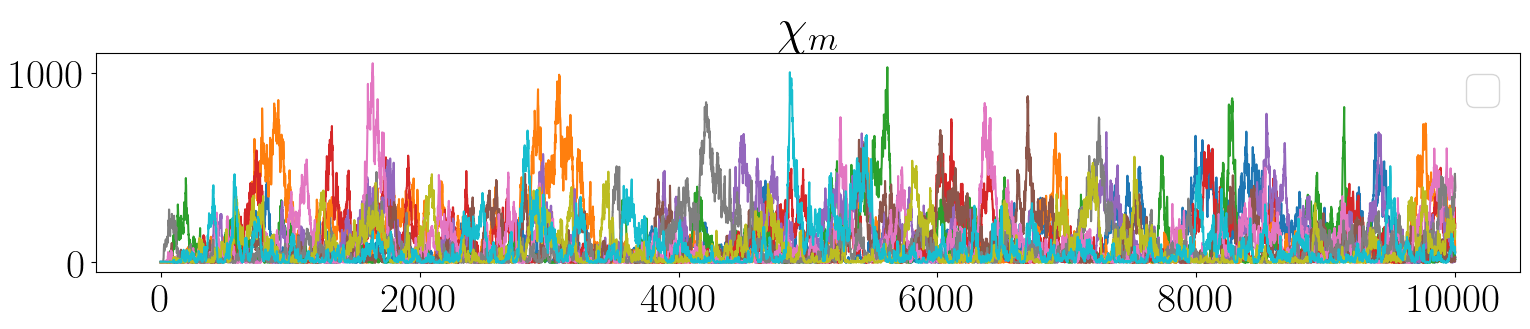

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


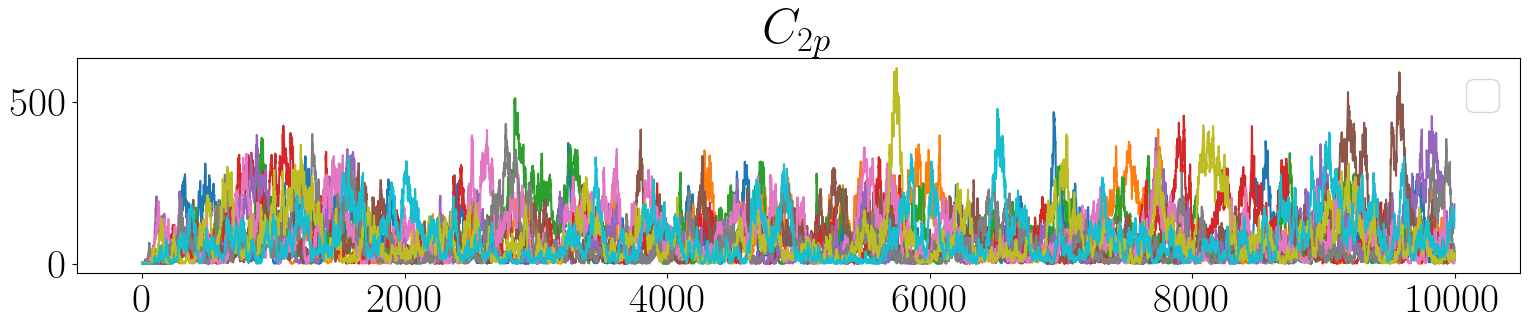

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


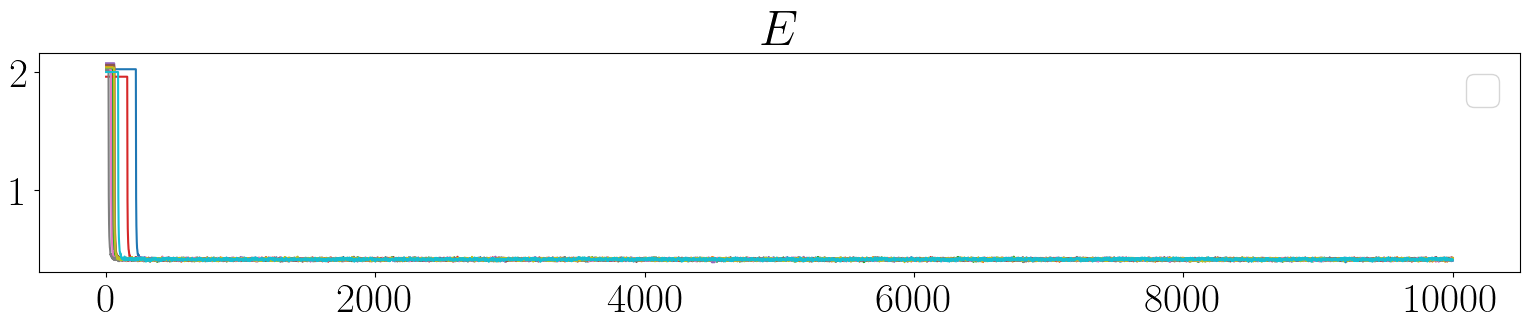

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


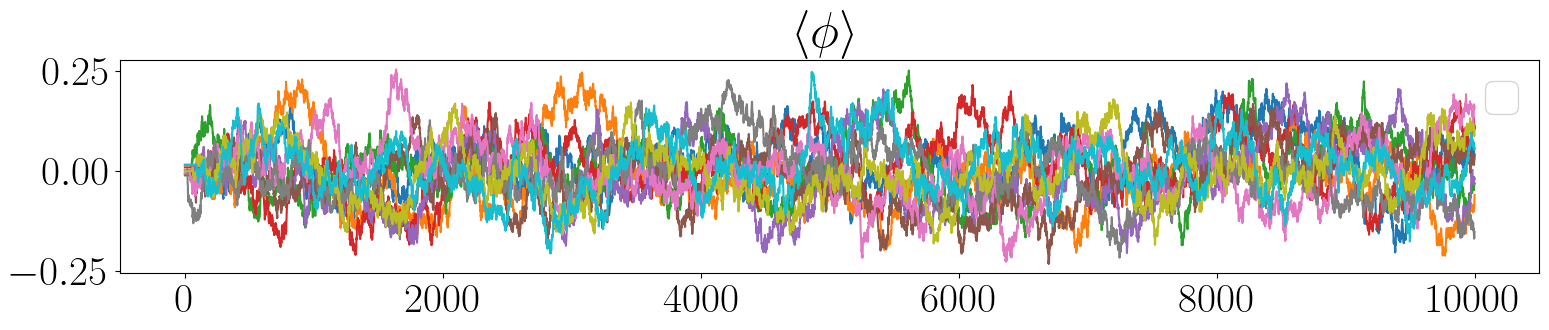

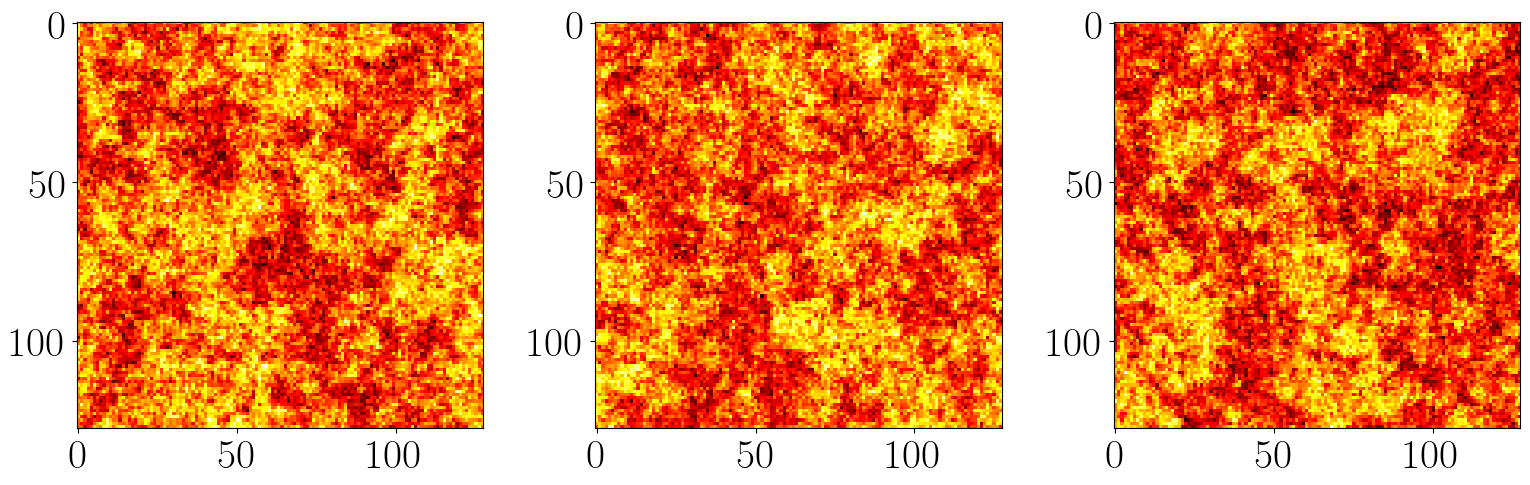

In [32]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(len(lchi_m)),lchi_m)#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(len(lC2p)),lC2p)#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(len(E)),E)#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(len(av_phi)),av_phi)#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:], cmap='hot', interpolation='nearest')


# Autocorrelation time
Given the formula for autocorrelation time
$$C_X(t) = \frac{1}{(N - t) \cdot \sigma^2} \sum_{i=0}^{N-t-1} (X_i - \bar{X})(X_{i+t} - \bar{X})?$$

torch.Size([3000])
Integrated autocorrelation time for M: 209.80585245698467
Integrated autocorrelation time for chi_m: 164.6775212782384


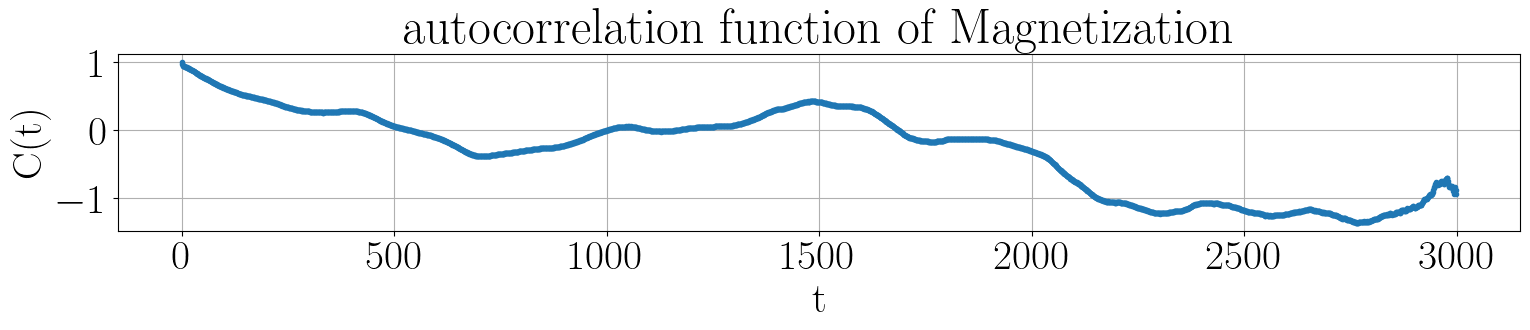

Text(0.5, 0, 't')

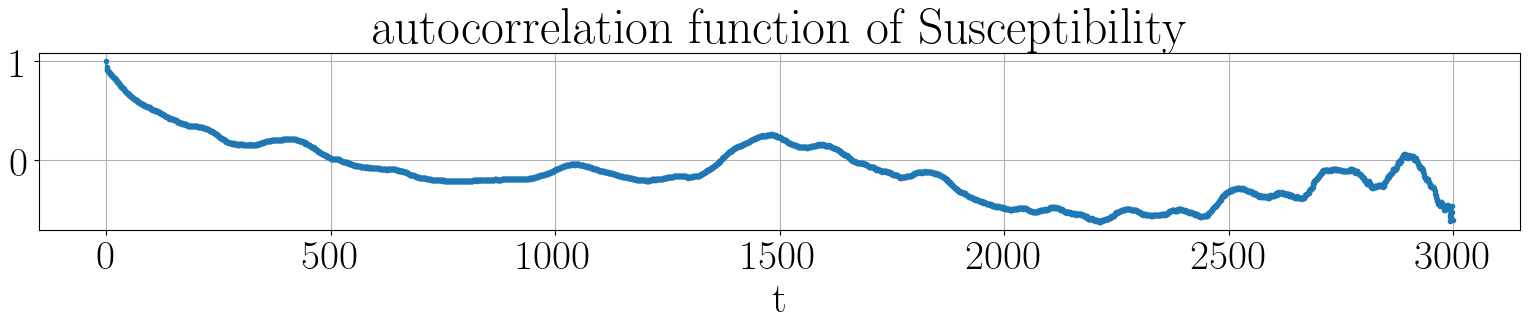

In [ ]:


acf_phi = autocorrelation(tr.tensor(av_phi))
#acf_phi = acf_phi / acf_phi[0]
acf_suscept = autocorrelation(tr.tensor(lchi_m))
print(acf_phi.shape)
tau_int_phi = integrated_autocorrelation_time(acf_phi,600)
tau_int_suscept = integrated_autocorrelation_time(acf_suscept,600)
print(f"Integrated autocorrelation time for M: {tau_int_phi}")
print(f"Integrated autocorrelation time for chi_m: {tau_int_suscept}")

plt.figure(figsize=(16, 4))
plt.plot(acf_phi[:5000], marker='.')
plt.title("autocorrelation function of Magnetization ")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.grid(True)
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(acf_suscept[:5000], marker='.')
plt.title("autocorrelation function of Susceptibility ")
plt.grid(True)
plt.xlabel("t")

# Multigrid

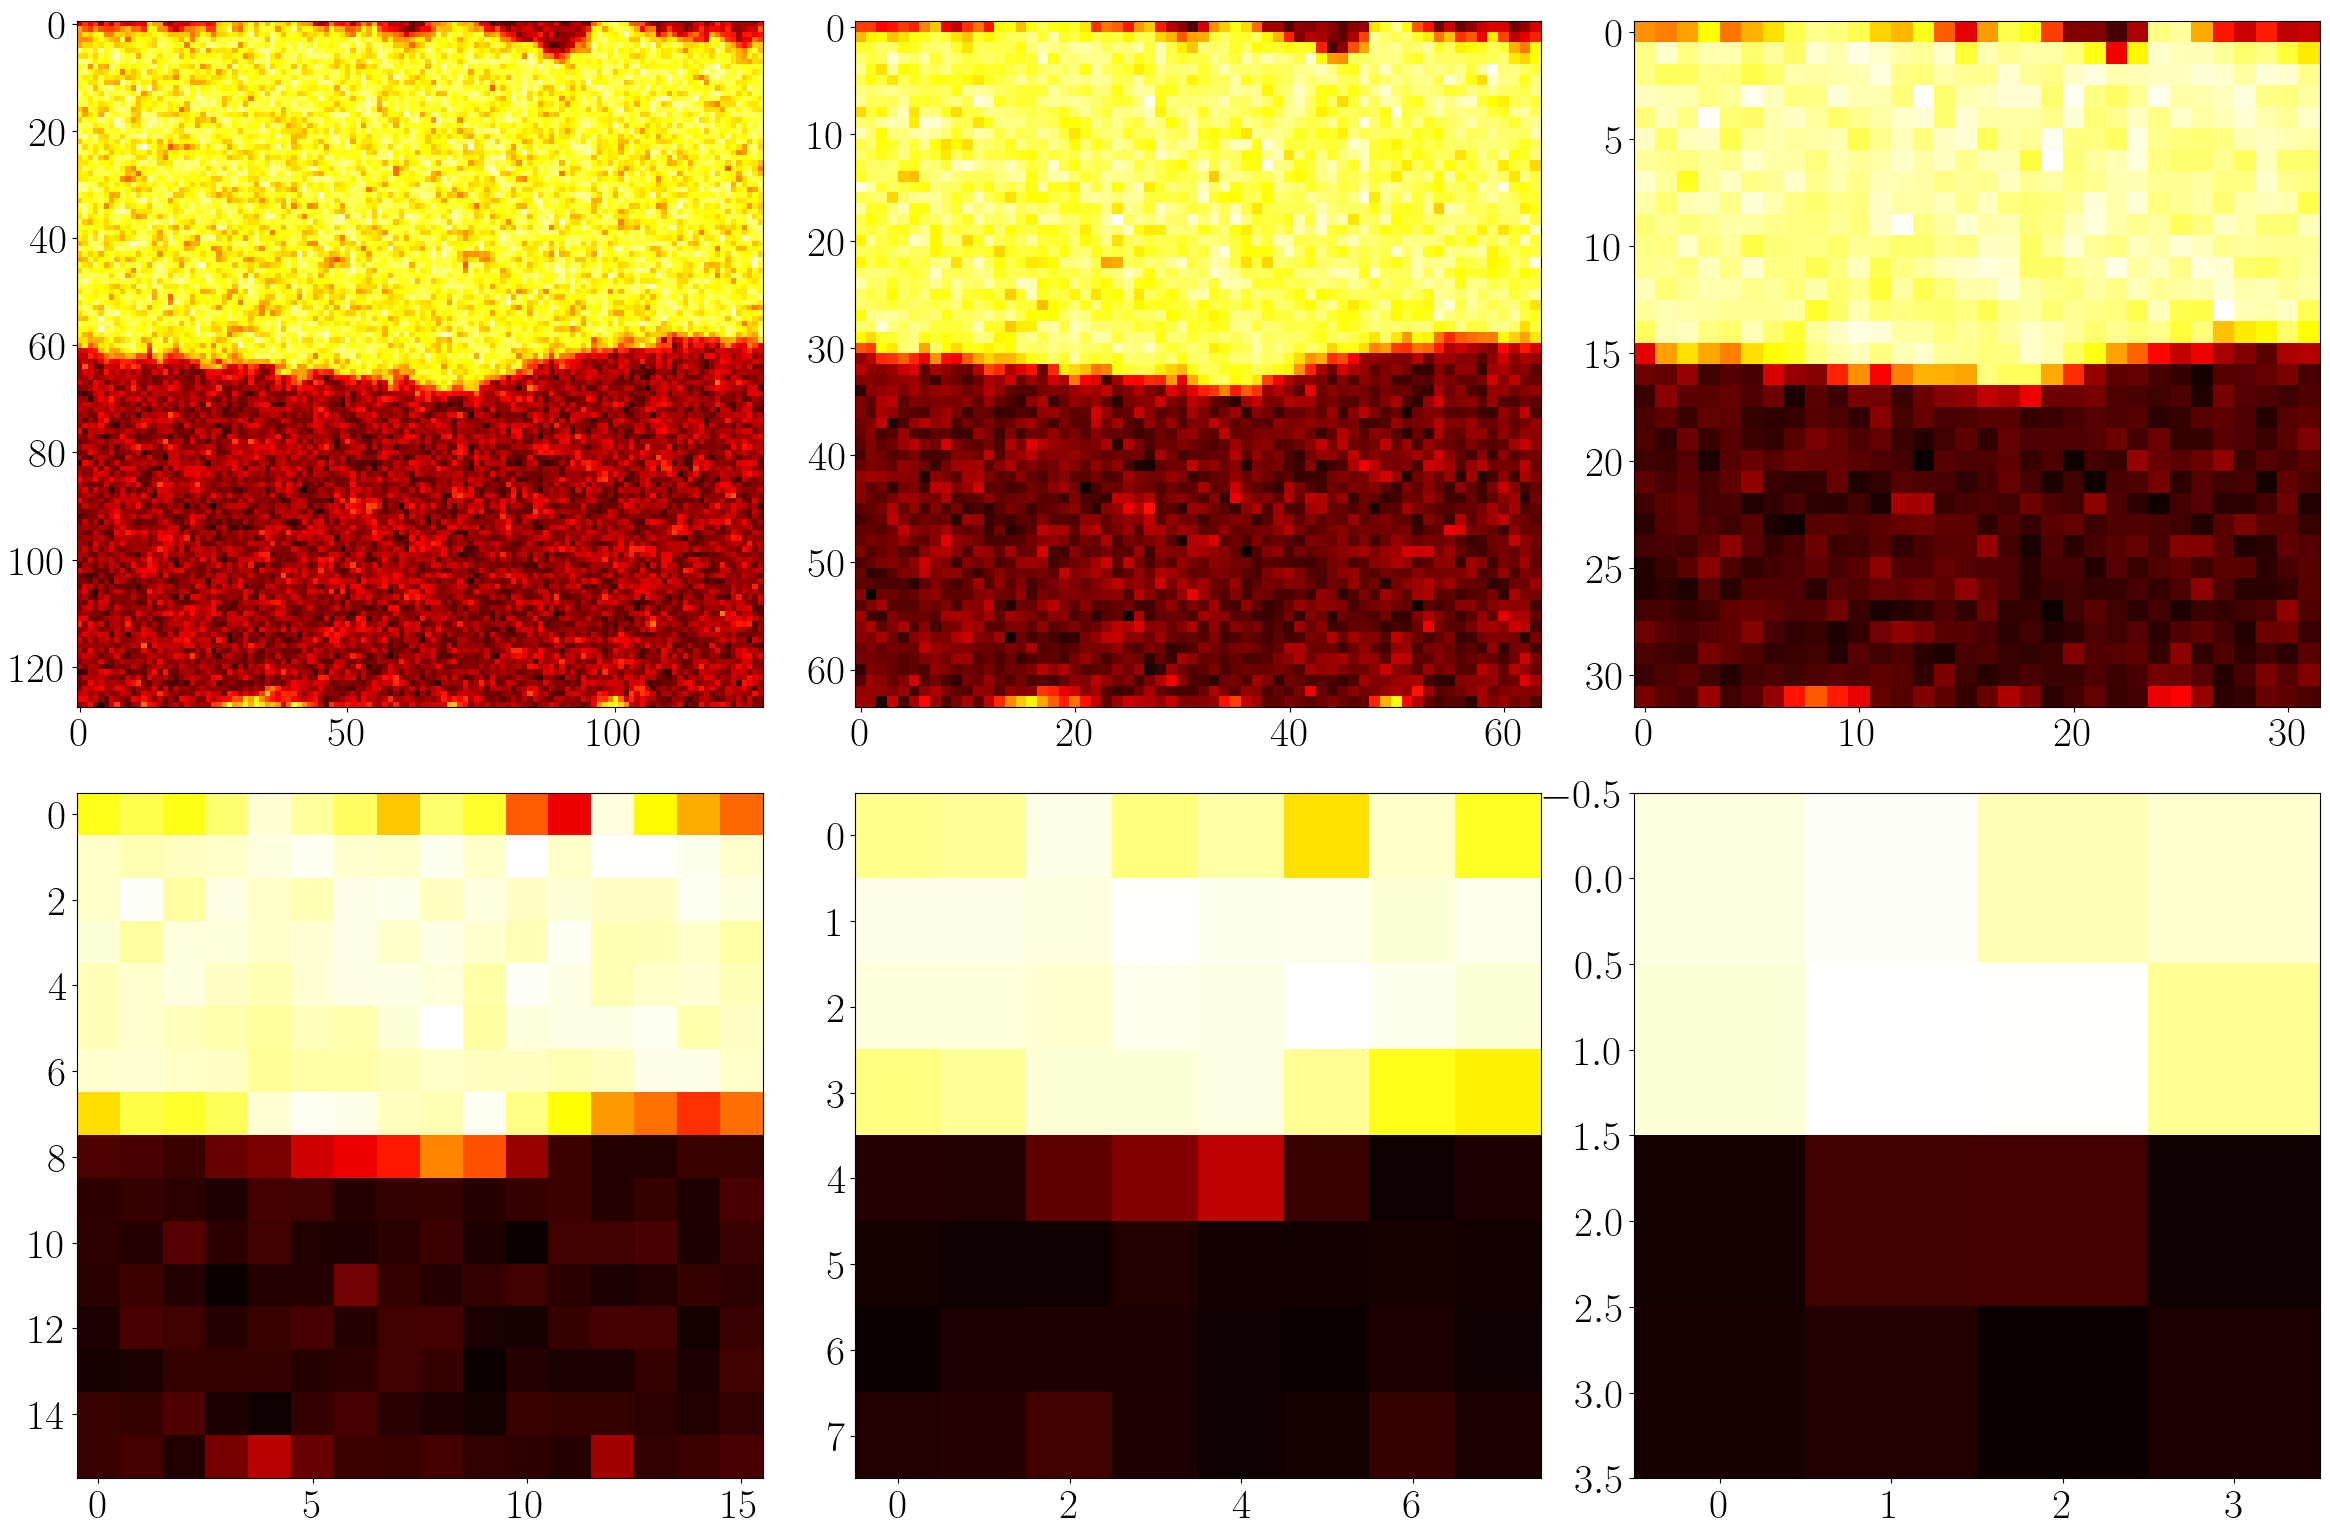

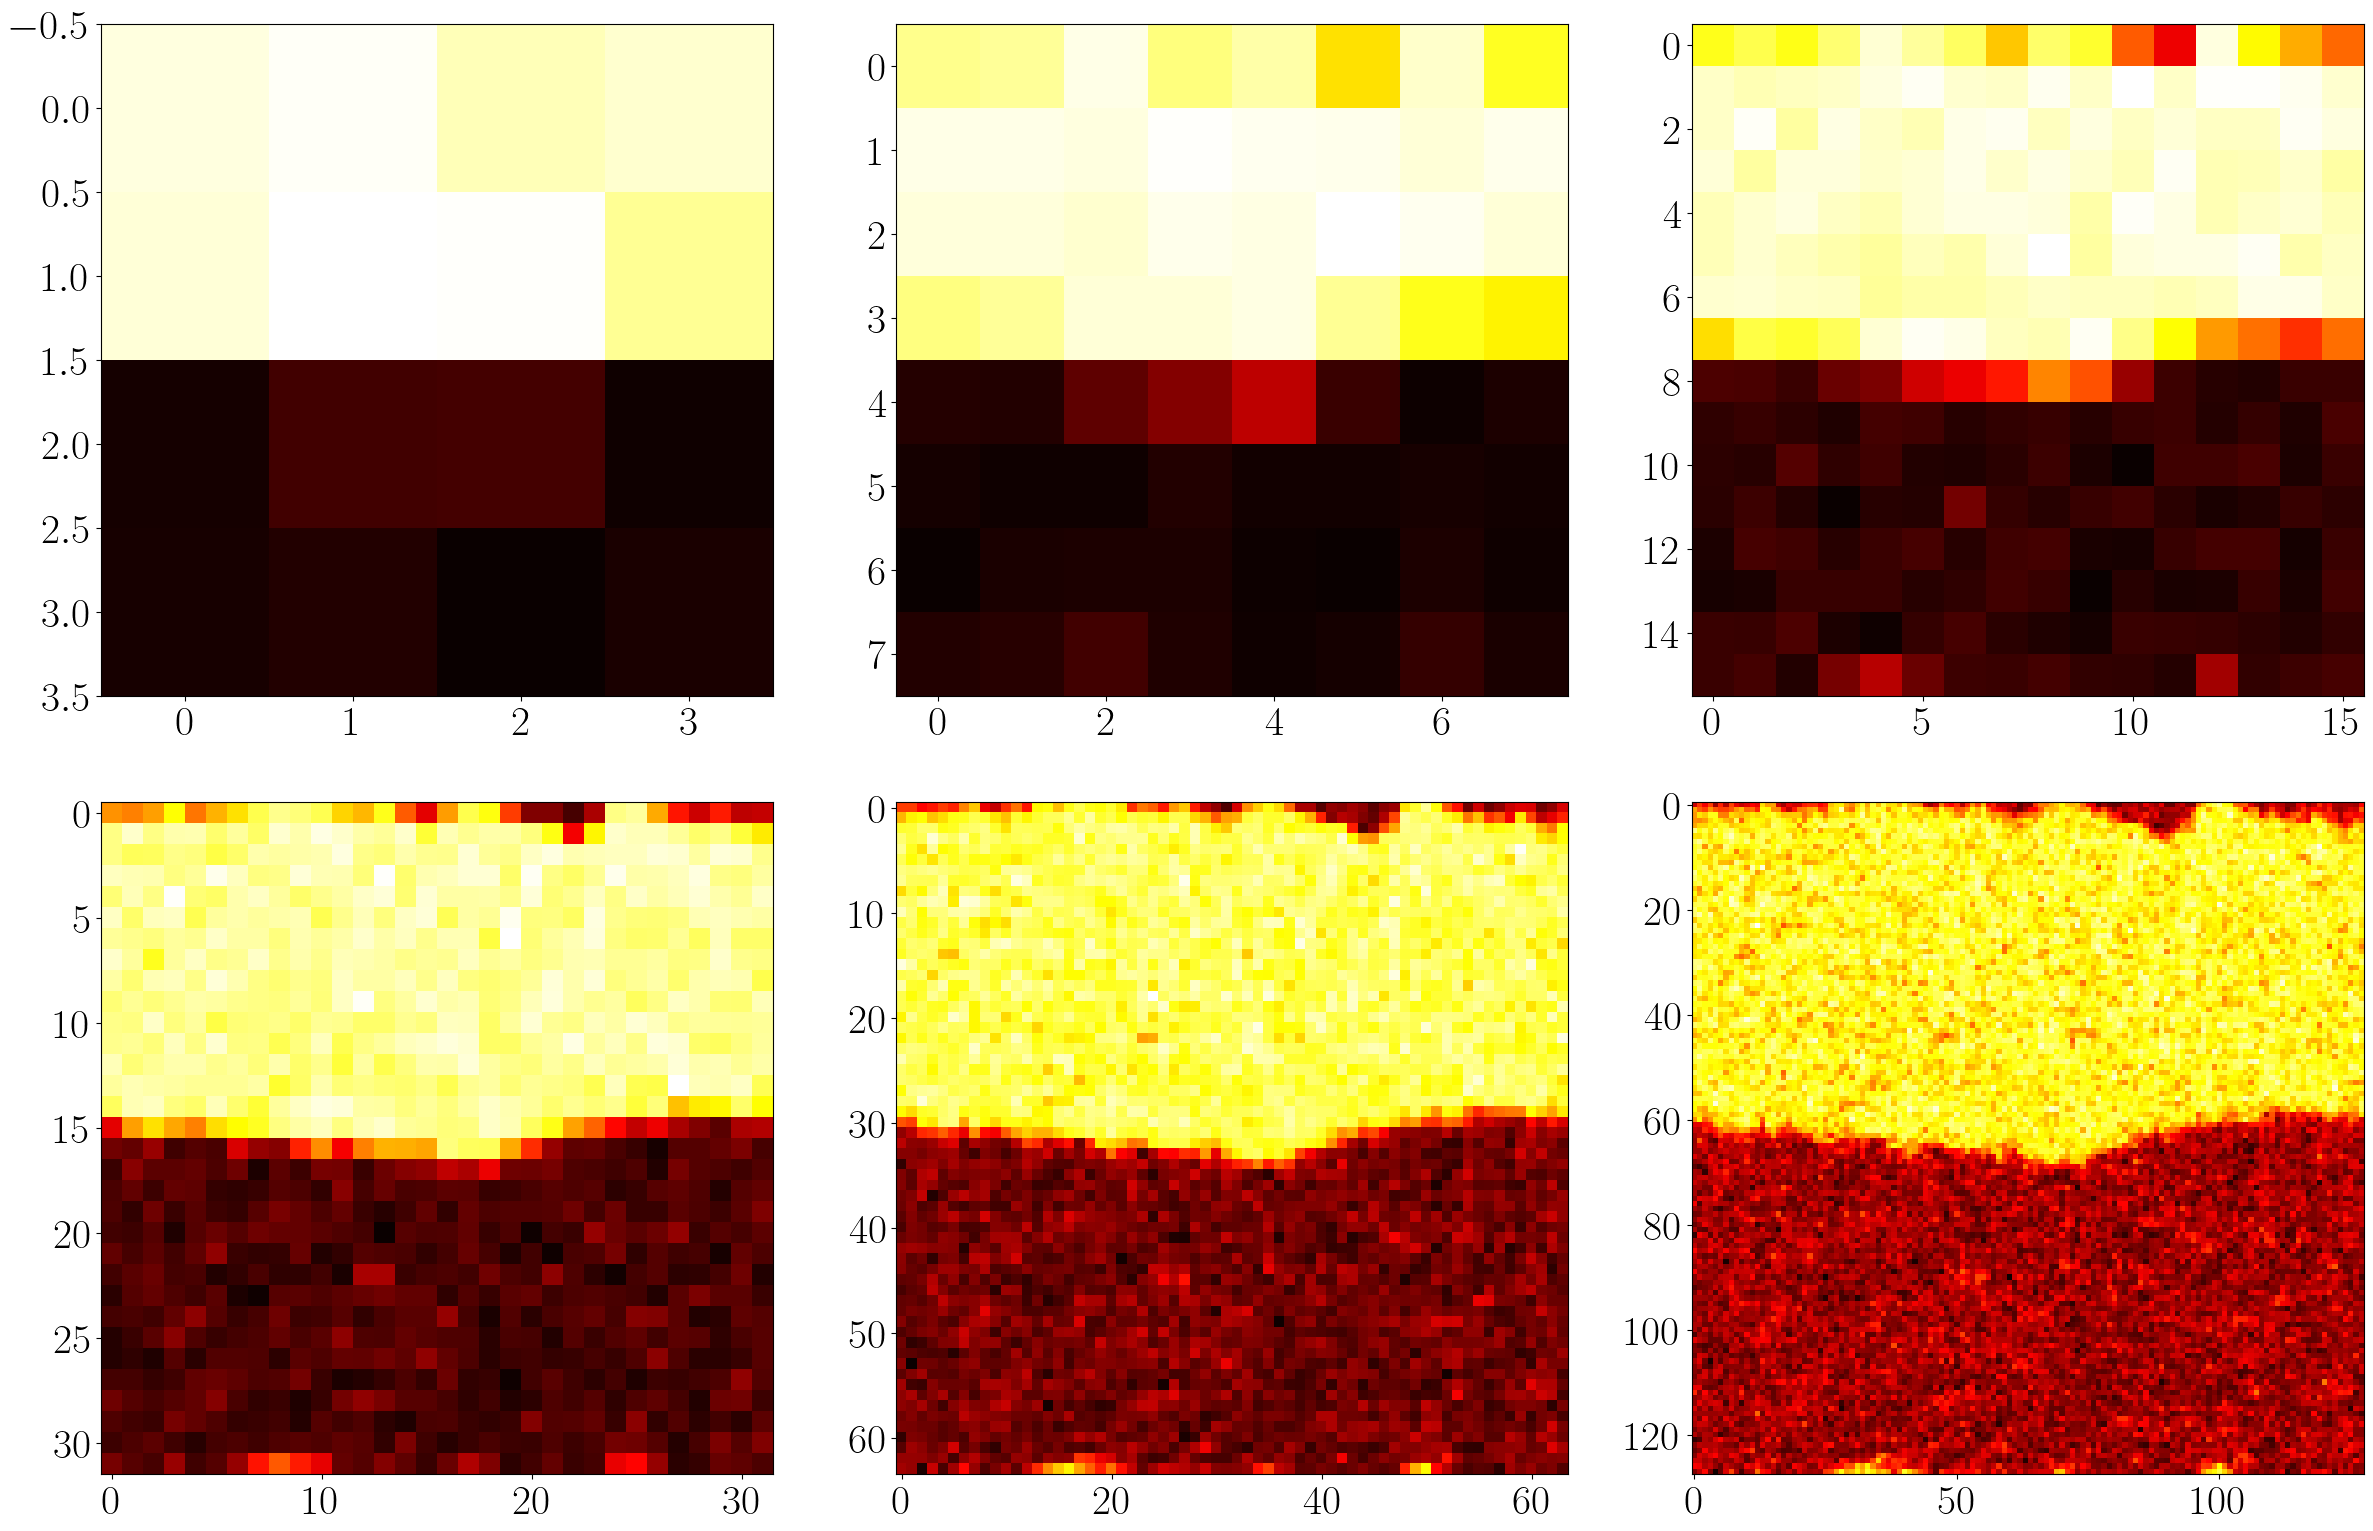

In [53]:
import phi4_mg as phimg
rg = phimg.RGlayer("average")
import integrators as i

phis=[]
pis=[]
phicopy=phi.clone()
phis.append(phi)
for _ in range(5):
    phic,pic = rg.coarsen(phicopy)
    phis.append(phic)
    pis.append(pic)
    phicopy=phic

#reversed
rphis=[]
rphis.append(phis[-1])
iii=0
for pics in reversed(pis):
    rphi = rg.refine(rphis[iii],pics)
    rphis.append(rphi)
    iii+=1

#plot the phi field
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(phis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(phis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(phis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(phis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(phis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(phis[5][0,:,:], cmap='hot', interpolation='nearest')
plt.show()
#one level up
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(rphis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(rphis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(rphis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(rphis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(rphis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(rphis[5][0,:,:], cmap='hot', interpolation='nearest')
#save figure
plt.savefig("rphis.pdf", bbox_inches='tight',dpi=300)
plt.show()
#one level down 

now we have to update the coarse field, and compare with any of the ml implementation in phi4_mg

In [11]:
class phi4_c1:
    def action(self,phi_c):
        rphis=[]
        rphis.append(phi_c)
        iii=0
        for pi in reversed(self.pics):
            #print(pi.shape)
            rphi = self.rg.refine(rphis[iii],pi)
            rphis.append(rphi)
            iii+=1
        phi_f = rphis[-1]
        #evaluate coarse field in action of rg
        #print(phi_f.shape,"shape of fine field")
        return self.sg.action(phi_f)
        #if I dont add the .sum() I got a grad for the batch system, it seems to me that we include that in the force property the batch is summed?

    def force(self, phi_c):
        x_tensor = phi_c.detach().clone().requires_grad_()

        S = -self.action(x_tensor)
        grad = tr.autograd.grad(S.sum(), x_tensor, retain_graph=True)[0]

        if grad is None:
            print("[ERROR] Gradiente es None.")
            raise RuntimeError("autograd.grad devolvió None")

        return grad
    
    def refreshP(self):
        P = tr.normal(0.0,1.0,self.phis[-1].shape)#only difference with fine level
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        return tr.einsum('bxy,bxy->b',P,P)/2.0

    def generate_cfg_levels(self,phi11,level):#run every time we need to contruct deeper or superficial levels
        #run a configuration
        self.level=level
        phis=[]
        pis=[]
        phicopy=phi11.clone()
        #print("shape of the original field",phicopy.shape)
        phis.append(phicopy)
        for _ in range(level):
            #print("coarsening level ",_," field shape ",phicopy.shape)
            phic,pic = self.rg.coarsen(phicopy)
            phis.append(phic)
            pis.append(pic)
            phicopy=phic
        self.phis=phis
        self.pics=pis

        #reversed
        rphis=[]
        rphis.append(phis[-1])
        for phics,pis in zip(reversed(phis),reversed(pis)):
            rphi = self.rg.refine(phics,pis)
            rphis.append(rphi)
        self.rphis=rphis

    def __init__(self,sgg,rgg):
        self.sg = sgg#theory? in the finest level
        self.rg = rgg#projector to coarse level



refining level  torch.Size([1, 32, 32])
refining level  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


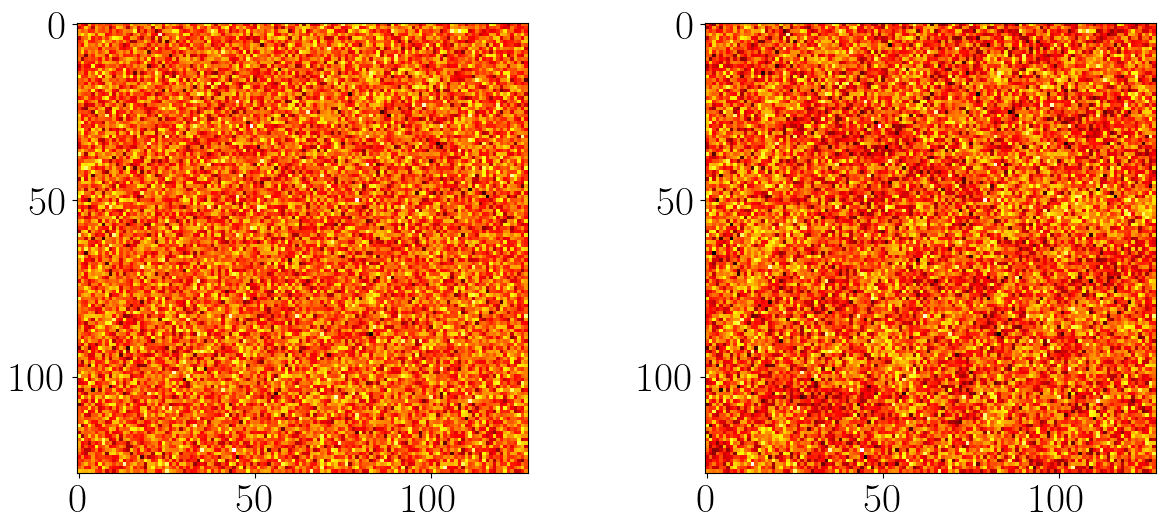

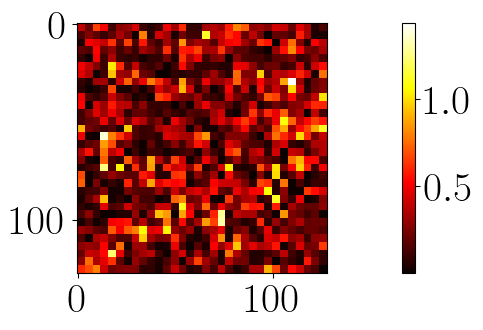

In [14]:
import phi4_mg as phimg
rg = phimg.RGlayer("average",batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=2
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phinew = hmc_2.evolve(phi2,1)
#phinew = phi2
for sss in reversed(range(Nlevels)):
    print("refining level ",phinew.shape)
    phinew= rg.refine(phinew,sg2.pics[sss])

#phinew=hmc.evolve(phinew,1)
ax[1].imshow(phinew[0,:,:], cmap='hot', interpolation='nearest')
fig.savefig("phi_fine_coarse.svg", bbox_inches='tight',dpi=300)
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()

In [ ]:
#still need to change the code of phi_coarse try Vcycle instead
def V_cycle(phi_o,sgc_c,rg_c,hmc_f,m1,m2,Nlevels,Nskip=1):
    phi_o= hmc_f.evolve(phi_o,m1)
    sgc = phi4_c1(sgc_c,rg_c)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi_o,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels)):
        phic_up= rg_c.refine(phic_up,sgc.pics[sss])

    #print("shape of fine field ",phic_up.shape)
    phic_up=hmc_f.evolve(phic_up,m2)
    return phic_up, hmcc.AcceptReject

def get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]))
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.extend(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.extend(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%10==0):
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().detach().numpy(),chi_m.mean().detach().numpy(),C2p.mean().detach().numpy(),ttE.mean().detach().numpy())
        lC2p.extend(C2p)
        lchi_m.extend(chi_m)
        ## HMC update but also V cycle
        phi,accept=V_cycle(phi,sg,rg,hmc,1,1,Lev)

    return lC2p, lchi_m, E, av_phi, phi

In [29]:
mass_grid2=np.linspace(-.585,-0.54,11)
tau_phi2=np.zeros_like(mass_grid2)
tau_suscept2=np.zeros_like(mass_grid2)
sss=0
for mas in mass_grid2:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 500
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = phimg.RGlayer("average",batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi2[sss],tau_suscept2[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(0.0118) tensor(1.0096)
time 0.0027 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  0.011823252 0.5725769 3.865077158537865 2.0244503


k=  10 (av_phi,chi_m, c2p, E)  0.00252552 0.026125317 52.63375697512146 0.42024308
k=  20 (av_phi,chi_m, c2p, E)  0.099727914 40.73741 29.60290709625535 0.37862876
k=  30 (av_phi,chi_m, c2p, E)  0.25219488 260.51486 65.18393187698389 0.36169606
k=  40 (av_phi,chi_m, c2p, E)  0.033830065 4.6877627 86.38775092215047 0.3913306
k=  50 (av_phi,chi_m, c2p, E)  -0.13540867 75.10224 329.27038367580803 0.37381122
k=  60 (av_phi,chi_m, c2p, E)  -0.22132966 200.65001 319.05025285101135 0.37678394
k=  70 (av_phi,chi_m, c2p, E)  -0.32762238 439.65 74.22161479099633 0.39590454
k=  80 (av_phi,chi_m, c2p, E)  -0.34614655 490.77222 99.98106526886741 0.38064218
k=  90 (av_phi,chi_m, c2p, E)  -0.41598314 708.7799 134.26582196033553 0.3898999
k=  100 (av_phi,chi_m, c2p, E)  -0.4488313 825.13727 28.717447276759792 0.3768624
k=  110 (av_phi,chi_m, c2p, E)  -0.5189409 1103.0515 50.41231823330891 0.35828376
k=  120 (av_phi,chi_m, c2p, E)  -0.44247493 801.9315 26.919454150614378 0.3789723
k=  130 (av_phi,chi_m

In [ ]:
mass_grid3=np.linspace(-.585,-0.54,6)
tau_phi3=np.zeros_like(mass_grid3)
tau_suscept3=np.zeros_like(mass_grid3)
sss=0
for mas in mass_grid3:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 10
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi3[sss],tau_suscept3[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(-0.0151) tensor(0.9927)
time 0.1403 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.015104491 0.9344846 0.09005918706005746 1.9716909


k=  10 (av_phi,chi_m, c2p, E)  -0.37677017 581.4508 16.373593413122094 0.40607983
k=  20 (av_phi,chi_m, c2p, E)  -0.509234 1062.1718 18.38932896016239 0.39865112
k=  30 (av_phi,chi_m, c2p, E)  -0.6199784 1574.3928 9.16200502544789 0.37060016
k=  40 (av_phi,chi_m, c2p, E)  -0.67207795 1850.1172 7.531855072658757 0.34692156
k=  50 (av_phi,chi_m, c2p, E)  -0.7205291 2126.4883 6.763256786391959 0.36446297
k=  60 (av_phi,chi_m, c2p, E)  -0.74507403 2273.8342 2.5607110574959373 0.3536834
k=  70 (av_phi,chi_m, c2p, E)  -0.859984 3029.2888 3.814437206222709 0.34161174
k=  80 (av_phi,chi_m, c2p, E)  -0.7739779 2453.675 0.5661553252756875 0.37053555
k=  90 (av_phi,chi_m, c2p, E)  -0.76859945 2419.692 1.883323628224898 0.31652868
k=  100 (av_phi,chi_m, c2p, E)  -0.7925014 2572.5273 4.0118689390430555 0.3192715
k=  110 (av_phi,chi_m, c2p, E)  -0.79144424 2565.6687 0.49470373007104335 0.32894552
k=  120 (av_phi,chi_m, c2p, E)  -0.7519648 2316.0876 2.631338128157484 0.33890897
k=  130 (av_phi,chi_m,

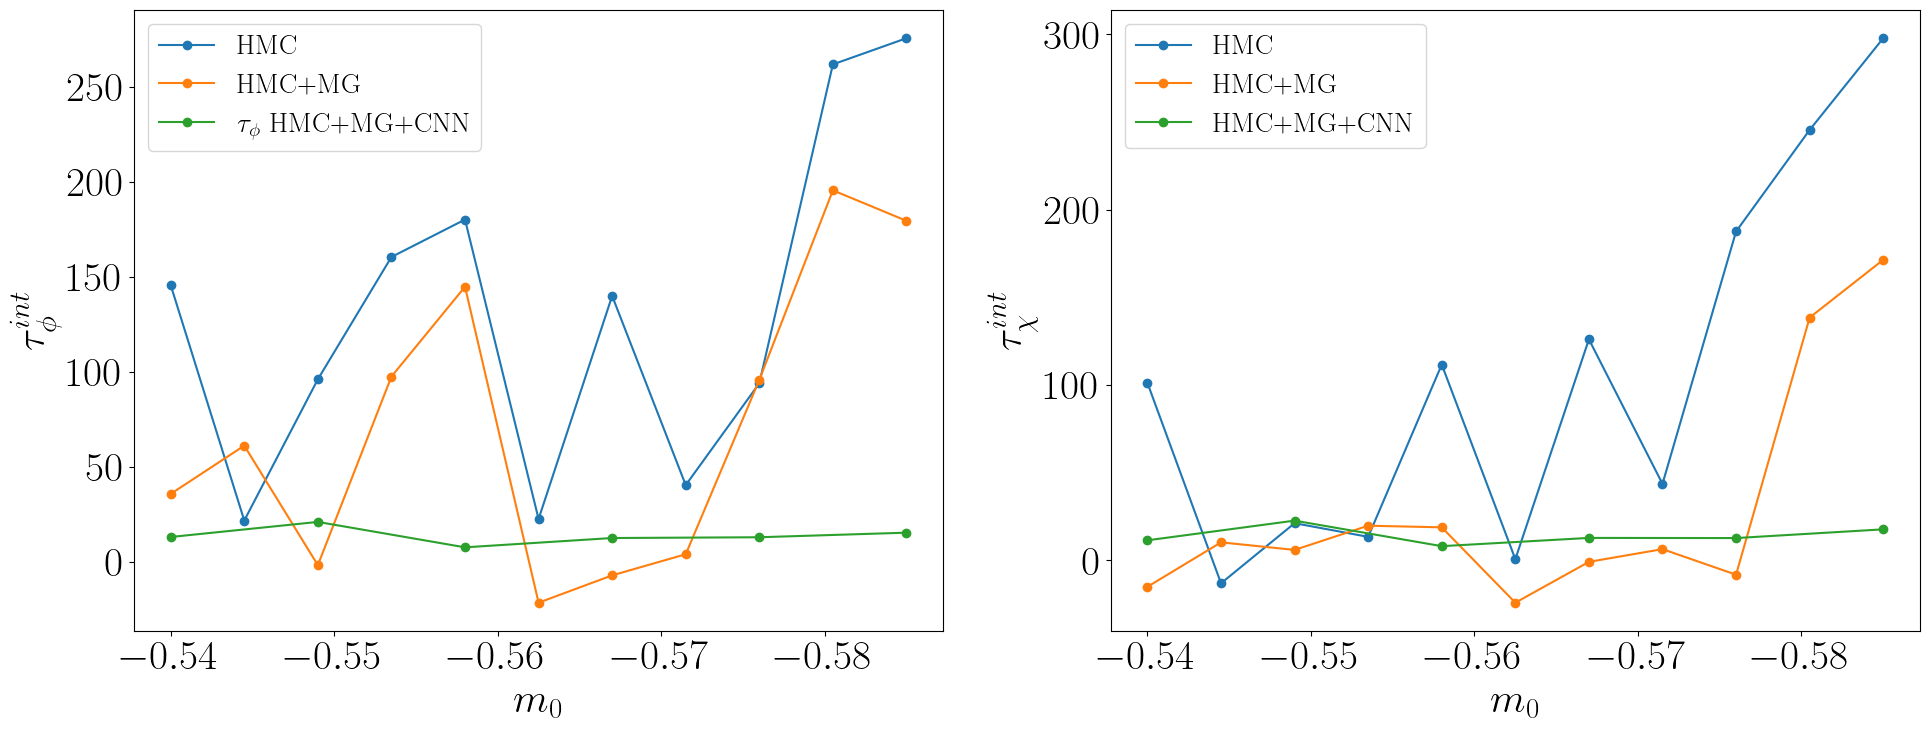

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#reverse mass axis ax
ax[0].invert_xaxis()
ax[0].plot(mass_grid1,tau_phi1,'o-',label=r'HMC')
ax[0].plot(mass_grid2,tau_phi2,'o-',label=r'HMC+MG')
ax[0].plot(mass_grid3,tau_phi3,'o-',label=r'$\tau_{\phi}$ HMC+MG+CNN')
ax[0].set_xlabel(r'$m_0$', fontsize=30)
ax[0].set_ylabel(r'$\tau_{\phi}^{int}$', fontsize=30)
ax[0].legend(fontsize=20)
ax[1].invert_xaxis()
ax[1].plot(mass_grid1,tau_suscept1,'o-',label=r'HMC')
ax[1].plot(mass_grid2,tau_suscept2,'o-',label=r'HMC+MG')
ax[1].plot(mass_grid3,tau_suscept3,'o-',label=r'HMC+MG+CNN')
ax[1].set_xlabel(r'$m_0$', fontsize=30)
ax[1].set_ylabel(r'$\tau_{\chi}^{int}$', fontsize=30)
ax[1].legend(fontsize=20)
#plt.savefig("tau_comparison.svg", bbox_inches='tight',dpi=300)
plt.show()

shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
shape of fine field  torch.Size([1, 64, 64])
shape of new field  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


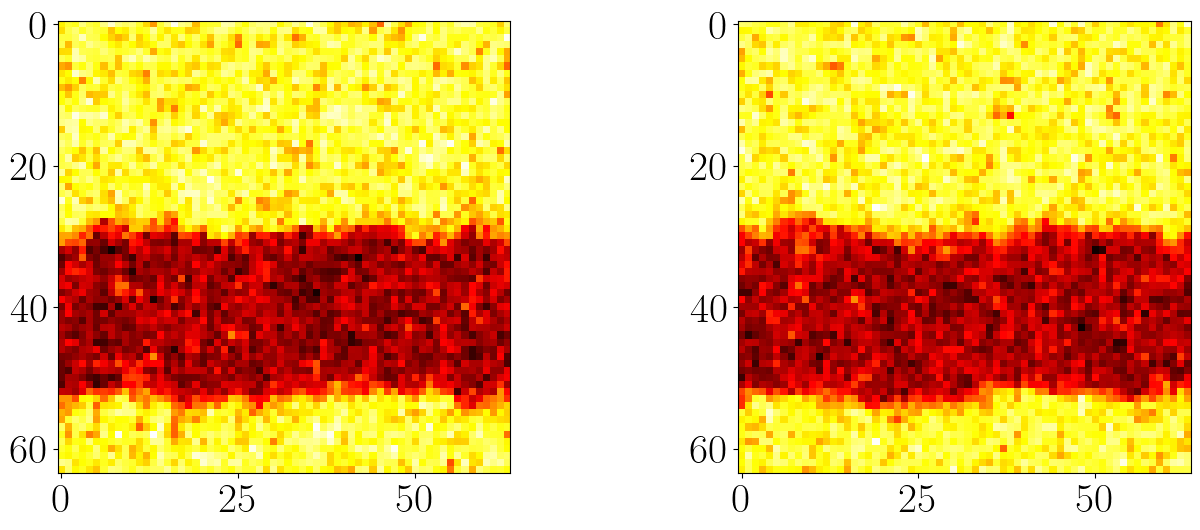

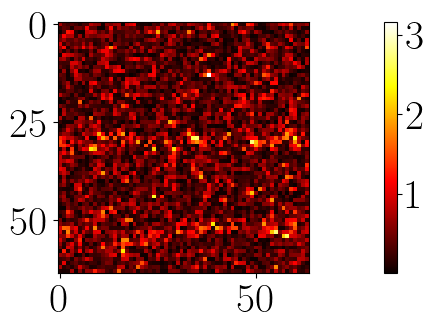

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phi_new,accept=V_cycle(phi,sg,rg,hmc,1,1,Nlevels=1)
print("shape of new field ",phi_new.shape)
ax[1].imshow(phi_new[0,:,:], cmap='hot', interpolation='nearest')
print("reject rate: ",accept )
diff=(phi-phi_new)
#plot diff
print(tr.tensor(accept).sum()/len(accept))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()


In [ ]:
#still need to change the code of phi_coarse try Vcycle instead
def Wcycle(phi,sg,rg,hmc_f,m1,m2,Nlevels=2,Nskip=1):

    sgc = phi4_c1(sg,rg)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels-1)):
        phic_up= rg.refine(phic_up,sgc.pics[sss])
    
    phic_up=hmc_f.evolve(phic_up,m1)
    return phic_up, hmcc.AcceptReject

256

In [56]:
phi_c = sg2.phis[-1]
phi_c.requires_grad_()
S = sg2.action(phi_c)
print("action", S)
grad = tr.autograd.grad(S.sum(), phi_c, retain_graph=True)[0]
print("grad ok? nan:", tr.isnan(grad).any(), "shape:", grad.shape)

action tensor([6299.9238], grad_fn=<SubBackward0>)
grad ok? nan: tensor(False) shape: torch.Size([1, 64, 64])


shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
coarsening level  1  field shape  torch.Size([1, 32, 32])
coarsening level  2  field shape  torch.Size([1, 16, 16])
torch.Size([1, 8, 8])
reject rate:  [1.0]
tensor(1.)


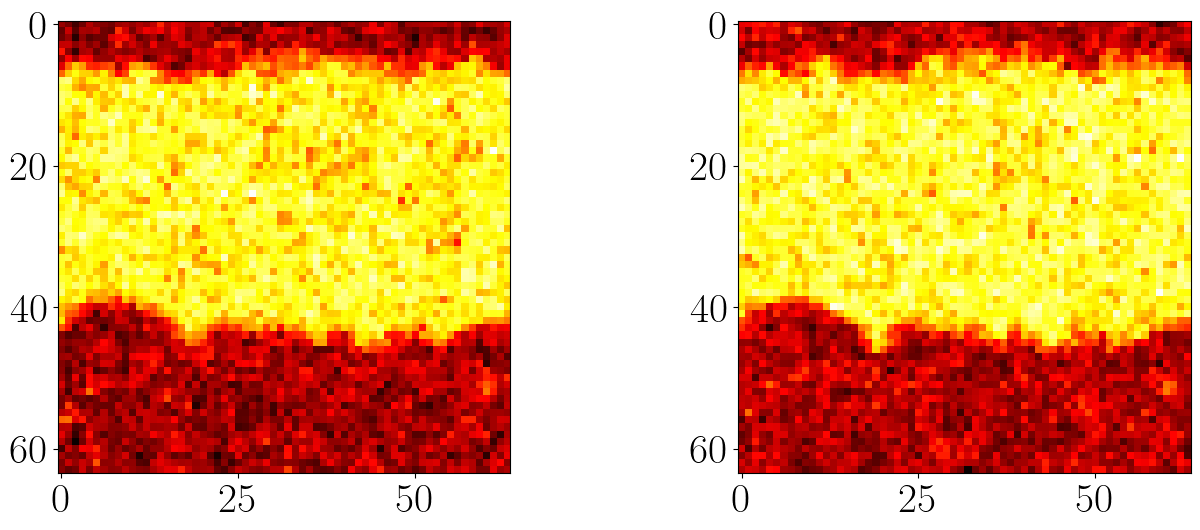

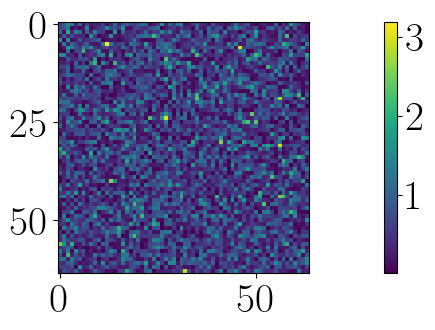

In [ ]:
import phi4_mg as phimg
#rg = NonLinearRGlayer("average",batch_size=batch_size)

rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=3
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
print(phi2.shape)
#remove gradient
#phi2 = phi2.detach()
#ax[1].imshow(phi2[0,:,:].detach(), cmap='hot', interpolation='nearest')

phinew = hmc_2.evolve(phi2,1)

for sss in reversed(range(Nlevels)):
    phinew= rg.refine(phinew,sg2.pics[sss])

phinew=hmc.evolve(phinew,10)
ax[1].imshow(phinew[0,:,:].detach(), cmap='hot', interpolation='nearest')
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), interpolation='nearest')
plt.colorbar()

 MG flow works but I have to figure out the coarsening procedure

In [24]:
normal = distributions.Normal(tr.zeros(Vol),tr.ones(Vol))
prior= distributions.Independent(normal, 1)

mg = phimg.MGflow([L,L],phimg.FlowBijector,phimg.RGlayer("average",batch_size==2),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)

print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())

def jwrap(x):
    z,_=mg.backward(x)
    return z

torchJacM = tr.autograd.functional.jacobian(jwrap,x)
print("Autograd jacobian matrix shape:",torchJacM.shape)
torchJacM = torchJacM.reshape(batch_size,Vol,batch_size,Vol)
print("Autograd jacobian matrix reshaped:",torchJacM.shape)
log_dets = []
diffs = []
for k in range(1):
    foo = torchJacM[k,:,k,:].squeeze()
    ldet  = np.log(foo.det().numpy())
    log_dets.append(ldet)
    diffs.append(np.abs(ldet - J[k].detach().numpy())/Vol)

print("log(Jacobians): ",log_dets)
print("Differences   : ",diffs)
    

Initializing MGflow module with size:  32
Using depth:  5
Using rg type:  average
(depth, size):  0 [32, 32]
(depth, size):  1 [16, 16]
(depth, size):  2 [8, 8]
(depth, size):  3 [4, 4]
(depth, size):  4 [2, 2]
Test reversibility (must be zero):  2.6313965e-06
torch.Size([2, 32, 32]) torch.Size([2, 32, 32])
the logprobs are:  [-6511.4326 -6283.6553]
Autograd jacobian matrix shape: torch.Size([2, 32, 32, 2, 32, 32])
Autograd jacobian matrix reshaped: torch.Size([2, 1024, 2, 1024])
log(Jacobians):  [62.896713]
Differences   :  [6.420243263244629]


In [26]:
Vol=np.prod(lat)
[phi.shape[1], phi.shape[2]],lat

([256, 256], [256, 256])

In [ ]:
lC2p_c = []
lchi_m_c = []
E_c = []
av_phi_c = []
lat_c=[phinew.shape[1],phinew.shape[2]]
Vol_c = np.prod(lat_c)
phase_c=tr.tensor(np.exp(1j*np.indices(tuple(lat_c))[0]*2*np.pi/lat_c[0]))
phi=sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
hmc = u.hmc(T=sg,I=mn2,verbose=False)
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)


    phi = hmc.evolve(phi,Nskip)

In [ ]:
phinew=hmc.evolve(phinew,10)

torch.Size([5, 128, 128]) 16384 tensor(0.0773) tensor(3.6547)


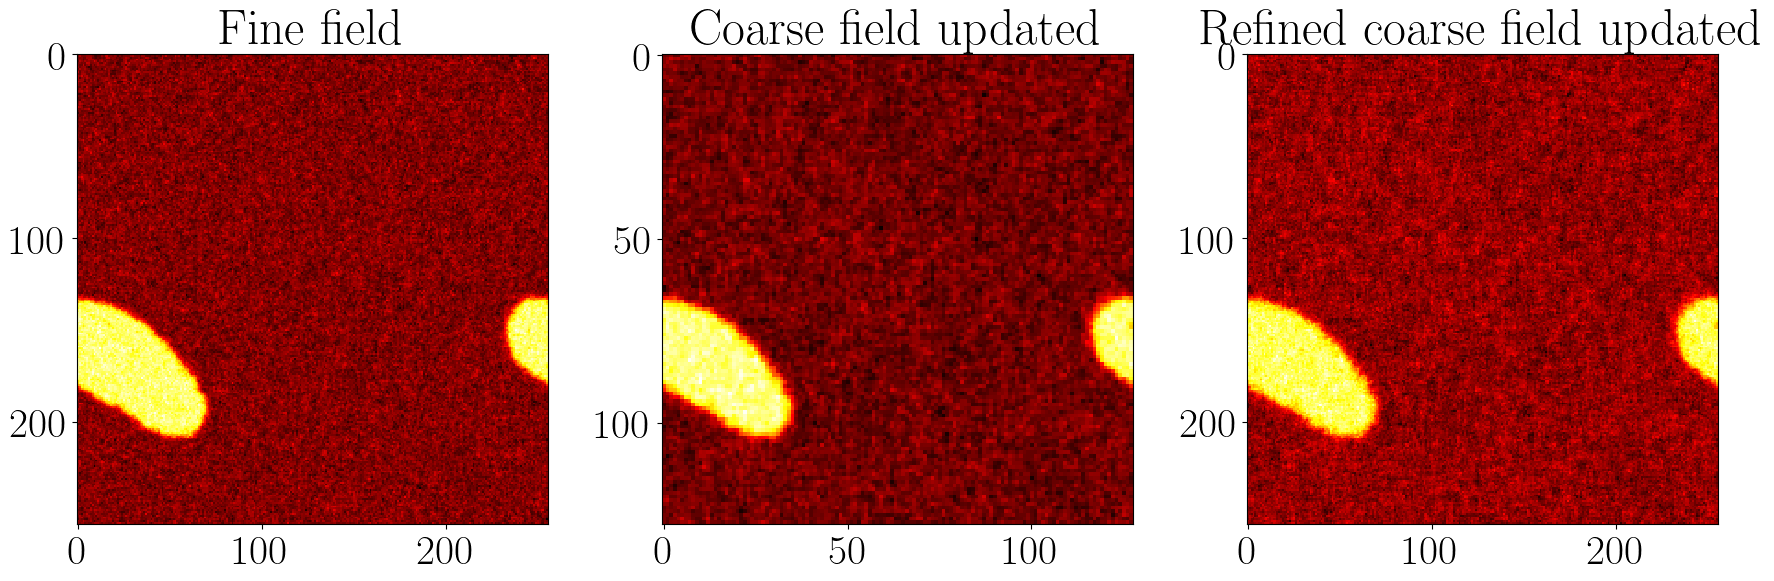

In [ ]:
#define the new lattice and simulate there but starting with the field phi2
L2 = L//2
lat2 = [L2,L2]
sg2 = s.phi4(lat2,lam,mas,batch_size=batch_size,device=device)
#phi2 = sg2.hotStart()
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
phi2 = phi2
print(phi2.shape,Vol//4,tr.mean(phi2),tr.std(phi2))

#mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
#print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
phi2 = hmc_2.evolve(phi2,1)

# If we want to come back to the fine lattice
rphi = rg.refine(phi2,pi)
rphi.shape
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
ax[0].set_title(f"Fine field")
ax[1].imshow(phi2[0,:,:], cmap='hot', interpolation='nearest')
ax[1].set_title(f"Coarse field updated")
ax[2].imshow(rphi[0,:,:], cmap='hot', interpolation='nearest')
ax[2].set_title(f"Refined coarse field updated")
plt.show()


This is a naive example of updating but with the wrong distribution. Fortunatelly, this is a linear transformation and the jacobian is 1 from $\psi, \pi \rightarrow \phi$

In [5]:
from phi4_mg import MGflow, FlowBijector, RGlayer

device = "cpu"
print(f"Using {device} device")

L=128

V=L*L
batch_size=4
lam =0.5
mass= -0.2
o  = p.phi4([L,L],lam,mass,batch_size=batch_size)

phi = o.hotStart()

#set up a prior
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)

mg = MGflow([L,L],FlowBijector,RGlayer("average"),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)


print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())


Using cpu device
Initializing MGflow module with size:  128
Using depth:  7
Using rg type:  average
(depth, size):  0 [128, 128]
(depth, size):  1 [64, 64]
(depth, size):  2 [32, 32]
(depth, size):  3 [16, 16]
(depth, size):  4 [8, 8]
(depth, size):  5 [4, 4]
(depth, size):  6 [2, 2]
Test reversibility (must be zero):  1.9628638e-07
torch.Size([4, 128, 128]) torch.Size([4, 128, 128])
the logprobs are:  [-24903.758 -24681.896 -24618.16  -24608.506]


In [13]:
mg.backward(phi)[1]

tensor([-1422.5790, -1435.3324, -1445.6223, -1395.2395],
       grad_fn=<AddBackward0>)